# Analizando chats de WhatsApp

## Consideraciones éticas
En este taller entenderemos las conversaciones de WhatsApp como privadas, por tanto:
 - Solo analizaremos conversaciones de las que somos parte
 - __No compartiremos con nadie los chats que analicemos sin el consentimiento de __todas__ las partes
 - Tomaremos medidas activas para evitar que ocurra lo anterior accidentalmente
 - Los resultados agregados que podamos compartir o publicar, deben velar por que __no se pueda hacer ingeniería inversa sobre estos para obtener datos a escala de individuo__.
 - La liberación o publicación de dichos resultados debe ser aprobada por la instructora de este taller, así como todas las partes del chat, o la administración de tratarse de un chat grupal que la tenga formalmente establecida (ej: WWCode).

## Obteniendo los archivos de desde WhatsApp
Desde WhatsApp en el telefono:
 - Tap al nombre de la conversación (contacto o grupo)
 - Scroll down hasta: Exportar Chat
 - Elegimos exportar sin media
 - Lo enviamos a nosotras mismas por el medio que nos acomode (archivos, telegram, mail, etc)
 - Recibiremos un zip, el que extraeremos a este directorio renombrado __chat.txt_ al nombre de la conversación.
 
## Importamos chat

In [2]:
import re
from unidecode import unidecode
# Open file and put it into a var
with open('ChatSTEM.txt', 'r', encoding='utf-8') as file:
    content = ''
    for line in file.readlines():
        content += line
# search, iterate and build an index trough opening datetime strings
regex = r"\[\d\d\.\d\d\.\d\d\,\ \d\d\:\d\d\:\d\d\]"
matches = re.finditer(regex, content, re.MULTILINE)
index = []
for match in matches:
    datetime = match.group()[1:-1]
    span = match.span()
    index.append([datetime, span])

In [3]:
from unidecode import unidecode

# Iterate over datetime and string list, and build a pre-table list with: datetime, kind, user and text
data = []
for idx in range(len(index) - 1):
    datetime = index[idx][0]
    
    start = index[idx][1][1]
    end = index[idx + 1][1][0]
    
    marker = content[start:end-1].find(b'\xe2\x80\x8e'.decode('utf-8'))
    if marker == -1:
        kind = 'message'
        user = content[start + 1:end-1].split(':')[0]
        text = content[start + len(user) + 3:end-1]
    else:
        if marker == 1:
            kind = 'admin action'
        else:
            kind = 'user action'
            
        raw_body = content[start + 1:end-1]
        colon_location = raw_body.find(':')
        if colon_location > 1:
            user = raw_body[:colon_location]
        else:
            hat_location = raw_body.find(' hat')
            user = raw_body[:hat_location]
        text = raw_body[len(user) + 1:].strip()
    
    data.append([datetime, kind, unidecode(user), text])

In [5]:
import pandas as pd

chat = pd.DataFrame(data, columns=['datetime', 'kind', 'user', 'text'])

## Veamos quienes escriben más

TypeError: no numeric data to plot

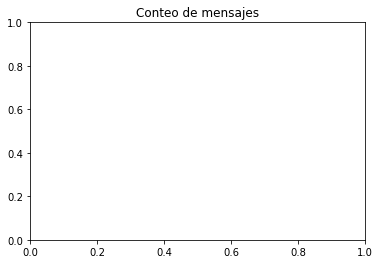

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
plt.title('Conteo de mensajes')

chat.user.value_counts()[:45].plot(kind='barh', figsize=(12, 14))

fig.savefig('message_count.png', bbox_inches='tight')

## Viendo usuarios específicos

In [7]:
user = ''
chat.query('user == @user')

,datetime,kind,user,text


In [24]:
user = '+56979807368' 
chat.query('user == @user')

,datetime,kind,user,text


# Creemos totales de palabras por usuario

In [12]:
import nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('spanish')

# lo de arriba fue por un error que aparecía con el ntlk

from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from unidecode import unidecode
from nltk.corpus import stopwords

# Stop words
stop_words = [
    'ja',
    'jaj',
    'jaja',
    'jajaj',
    'jajaja',
    'jajajaj',
    'jajajaja',
    'jajajajaj',
    'y',
    'q',
    '...',
    '',
    'si',
    'https',
    'mas',
    'xd'
] + stopwords.words("spanish")
puctuation = '1234567890¡!"·$%&/()=?¿",.-;:_–'
for simbol in puctuation:
    stop_words.append(simbol)

def user_words(df, stem = False, do_unidecode = True):
    # Count data structure
    user_words = {}
    # Count data
    for _idx, row in chat.iterrows():
        if row.kind == 'message':
            for word in word_tokenize(row.text):
                word = word.lower()
                if do_unidecode:
                    word = unidecode(word)
                
                if word not in stop_words:
                    # Build user if not already done
                    if row.user not in user_words.keys():
                        user_words[row.user] = {}
                    if word in user_words[row.user].keys():
                        user_words[row.user][word] += 1
                    else:
                        user_words[row.user][word] = 1
    # Sumarize data
    totals = []
    for user in user_words.keys():
        for word in user_words[user].keys():
            totals.append([user, word, user_words[user][word]])
    return(pd.DataFrame(totals, columns=['user', 'word', 'total']).sort_values('total', ascending=False))
                
uw = user_words(chat)
uw[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dafne\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,user,word,total


In [13]:
uw.groupby('word').sum().sort_values('total', ascending=False)[:20] #.iloc[0]

,user,total
word,,


In [14]:
def count_words(df, words):
    total_words = df.groupby('word').sum()
    result = {}
    for words_group in words:
        totals = []
        for word in words_group:
            if word in total_words.index:
                totals.append(total_words.loc[word].total)
            else:
                totals.append(0)
                
        ratios = []
        total_group = sum(totals)
        for count in totals:
            if total_group != 0:
                ratios.append(count/total_group)
            else:
                ratios.append(0)
                
        result['/'.join(words_group)] = (totals, ratios)
    return result

interest_words = [
 #   ['mujeres', 'hombres'],
  #  ['mujer', 'hombre'],
    ['ingeniera', 'ingeniero'],
    ['todas', 'todes', 'todos'],
    ['chicas', 'chiques', 'chicos'],
    ['jefa', 'jefe'],
    ['amiga', 'amigo'],
    ['gerenta', 'gerente'],
    ['polola', 'pololo'],
    ['cientifica', 'cientifico'],
    ['doctora', 'doctor'],
    ['tonta', 'tonto'],
    ['estupido', 'estupida'],
    ['mina', 'mino']
#    ['python', 'ruby', 'javascript', 'java', 'php']
]
#count_words(uw, interest_words) #.sort_values('word')

In [15]:
data = []
for key, values in count_words(uw, interest_words).items():
    #print(key)
    for i, word in enumerate(key.split('/')):
        #print(values[0][i],word)
        gender_count = len(key.split('/'))
        if gender_count == 2:
            genders = ['femenina', 'masculina']
        elif gender_count == 3:
            genders = ['femenina', 'no-binaria','masculina']
        else:
            genders = ['no-binaria' + str(n) for n in range(gender_count)] 
        data.append([key.replace('/', '\n'), word, values[0][i], values[1][i], genders[i]])
#data

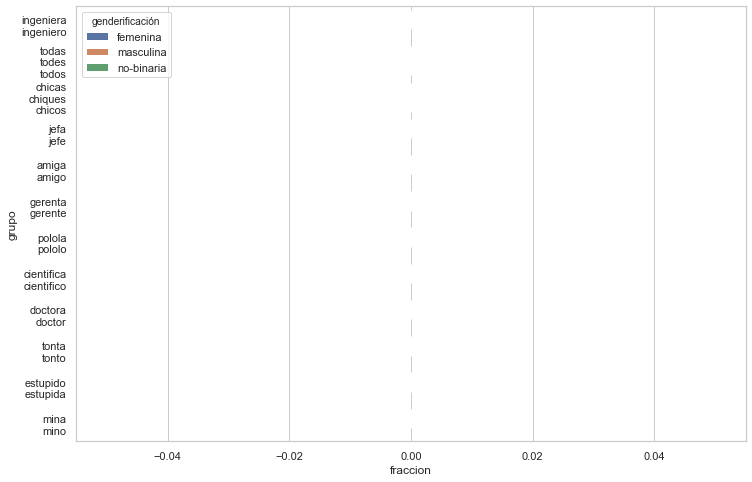

In [16]:
import seaborn as sns

genderificaciones = pd.DataFrame(data, columns=['grupo', 'palabra', 'total', 'fraccion', 'genderificación'])
sns.set(style="whitegrid")
fig = plt.figure(figsize=(12, 8))
#plt.xticks(rotation=90)
ax = sns.barplot(x="fraccion", y="grupo", hue="genderificación", data=genderificaciones)

fig.savefig('genderificaciones.png')

In [17]:
def count_words_sin(df, words):
    total_words = df.groupby('word').sum()
    result = {}
    for word in words:
        if type(word) == list:
            label = word[0]
            word_total = 0
            for variant in word:
                if variant in total_words.index:
                    word_total += total_words.loc[variant].total
        else:
            label = word
            if word in total_words.index:
                word_total = total_words.loc[word].total
        result[label] = word_total
    return result

lenguajes= [
    'python',
    'ruby',
    'java',
    ['javascript', 'js', 'typescript'],
    ['c++', 'algoquenoexiste'],
    'php',
    'fortran',
    'basic',
    'julia'
]

count_words_sin(uw, lenguajes)

UnboundLocalError: local variable 'word_total' referenced before assignment

In [18]:
counts = count_words_sin(uw, lenguajes)
lang_count = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])

lang_count.sort_values(by='count', ascending=False).plot(kind='barh', figsize=(12, 8))

UnboundLocalError: local variable 'word_total' referenced before assignment

# Creando clusters de palabras/usuarios

In [19]:
from sklearn import cluster

users = pd.get_dummies(uw.user, sparse=True)
words = pd.get_dummies(uw.word, sparse=True)
X = pd.concat([users, words], axis=1, sort=False)

clusterizer = cluster.KMeans(n_clusters=5, n_jobs=-1)

clusters = clusterizer.fit_predict(X, sample_weight=uw.total)

ValueError: at least one array or dtype is required